<a href="https://colab.research.google.com/github/dev0419/DL_Lab/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms,datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset,DataLoader

In [25]:
train_data = datasets.MNIST(root='./data',download=True,train=True,transform=ToTensor(),target_transform=None)
test_data = datasets.MNIST(root='./data',download=True,train=False,transform=ToTensor())

In [26]:
train_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=32)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [29]:
train_features_batch,train_labels_batch = next(iter(train_loader))
print(f"train_features_batch.shape:{train_features_batch.shape}\nlength of train_features batch:{len(train_features_batch)}")
print(f"train_labels_batch.shape:{train_labels_batch.shape}\nlength of train_labels batch:{len(train_labels_batch)}")

train_features_batch.shape:torch.Size([32, 1, 28, 28])
length of train_features batch:32
train_labels_batch.shape:torch.Size([32])
length of train_labels batch:32


(-0.5, 27.5, 27.5, -0.5)

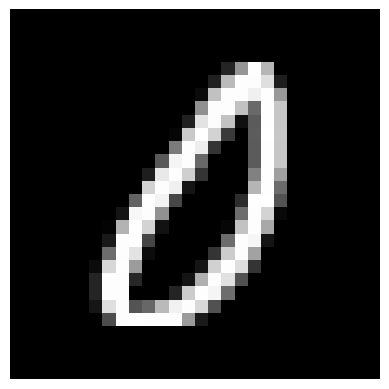

In [30]:
torch.manual_seed(42)
rand_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,labels = train_features_batch[rand_idx],train_labels_batch[rand_idx]
plt.imshow(img.reshape((28,28)),cmap='gray')
plt.axis('off')

In [31]:
class CNNclf(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=3),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2))
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 20, bias=True),
            nn.ReLU(),
            nn.Linear(20, 10, bias=True))

    def forward(self, x):
        x = self.net(x)
        #print(f"conv layer shape: {x.shape}")
        x = self.clf(x)
        #print(f"classifier shape: {x.shape}")
        return x

In [32]:
model = CNNclf().to(device)
#rand_img_tensor = torch.rand(1,28,28)
#rand_img_tensor.shape
model

CNNclf(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [33]:
#model(rand_img_tensor.unsqueeze(dim=0).to(device))

In [34]:
def accuracy_fn(y,y_pred):
    correct = torch.eq(y_pred,y).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)


In [36]:
def train_step(model,data_loader,device,optimizer,loss_fn,accuracy_fn):
    train_loss,train_acc = 0,0
    model.to(device)
    for batch,(X,y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} Train accuracy: {train_acc:.5f}")


def test_step(model,data_loader,device,optimizer,loss_fn,accuracy_fn):
    test_loss,test_acc = 0,0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred,y)
            test_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}")


In [37]:
torch.manual_seed(42)
epochs = 3
for epoch in range(epochs):
    print(f"Epoch:{epoch}\n--------")
    train_step(model,train_loader,device,optimizer,loss_fn,accuracy_fn)
    test_step(model,test_loader,device,optimizer,loss_fn,accuracy_fn)


Epoch:0
--------
Train loss: 0.21370 Train accuracy: 93.30667
Test loss: 0.08473 | Test accuracy: 97.15455
Epoch:1
--------
Train loss: 0.06402 Train accuracy: 98.01667
Test loss: 0.07957 | Test accuracy: 97.39417
Epoch:2
--------
Train loss: 0.04396 Train accuracy: 98.58833
Test loss: 0.04499 | Test accuracy: 98.56230


In [40]:
import os
import torch

# Define the directory path
directory = '/content/models'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the checkpoint
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, os.path.join(directory, 'checkpoint.pth'))


In [42]:
train_dataset = datasets.FashionMNIST(root='./data',download=True,train=True,transform=ToTensor(),target_transform=None)
test_dataset = datasets.FashionMNIST(root='./data',download=True,train=False,transform=ToTensor())

100%|██████████| 26421880/26421880 [00:02<00:00, 9923355.71it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 166260.02it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3176821.45it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18923993.86it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [51]:
import torch
import os


# Define the directory path and filename of the checkpoint
checkpoint_path = '/content/models/checkpoint.pth'
checkpoint = CNNclf()
# Load the checkpoint
checkpoint = torch.load(checkpoint_path)


# Load the model's state_dict from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Create an instance of your optimizer

# Load the optimizer's state_dict from the checkpoint
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])




{'epoch': 2,
 'model_state_dict': OrderedDict([('net.0.weight',
               tensor([[[[ 0.2026, -0.0948,  0.3371],
                         [-0.1016,  0.0953, -0.1875],
                         [ 0.1671,  0.2763, -0.2929]]],
               
               
                       [[[ 0.2344,  0.1138,  0.3578],
                         [ 0.0658,  0.2322, -0.0154],
                         [ 0.2872,  0.0713, -0.1801]]],
               
               
                       [[[ 0.0692, -0.1423, -0.0326],
                         [-0.2127,  0.2165, -0.2999],
                         [-0.1538, -0.1206, -0.1992]]],
               
               
                       [[[-0.2502, -0.4179,  0.3096],
                         [-0.5122,  0.2738,  0.1346],
                         [-0.1070,  0.2793,  0.0578]]],
               
               
                       [[[ 0.3107,  0.0646, -0.1177],
                         [ 0.1441, -0.0532,  0.1319],
                         [ 0.3477,  0.2347, 